### Importing the necessary packages
The keras applications that are not going to be used can be commented out.

In [182]:
# import the necessary packages
import tensorflow as tf
import numpy as np
import argparse
import cv2
import glob
import os
import math
import random
# from tensorflow.python.keras._impl.keras.applications import ResNet50
# from tensorflow.python.keras._impl.keras.applications import InceptionV3
# from tensorflow.python.keras._impl.keras.applications import Xception # TensorFlow ONLY
# from tensorflow.python.keras._impl.keras.applications import VGG16
# from tensorflow.python.keras._impl.keras.applications import VGG19
# from tensorflow.python.keras._impl.keras.applications import imagenet_utils
from tensorflow.python.keras._impl.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras._impl.keras.preprocessing import image
from tensorflow.python.keras._impl.keras.models import Model
from tensorflow.python.keras._impl.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.python.keras._impl.keras.preprocessing.image import img_to_array
# from tensorflow.python.keras._impl.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [183]:
%matplotlib inline

### Defining paths for the data

In [184]:
# Paths
data_path = 'dogscats/'
train_path = 'dogscats/train/'
valid_path = 'dogscats/valid/'
test_path = 'dogscats/test/'
sample_path = 'dogscats/sample/'
sample_train_path = 'dogscats/sample/train/'
sample_valid_path = 'dogscats/sample/valid/'

Sample sets are smaller sets to quickly check if the model constructed is correct.
<br>Comment out the 2 lines below when running on the main training set (takes time).

In [185]:
train_path = sample_train_path
valid_path = sample_valid_path
num_classes = len(glob.glob(train_path + "/*"))
print('Number of classes found:', num_classes)

Number of classes found: 2


## Define certain hyperparameters

In [186]:
epochs = 5
batch_size = 16 # Use in the multiples of 2
fc_size = 1024

activation = 'relu' # Activation for the top FC layers
lr = 0.001 # Learning rate for the optimizer
loss='binary_crossentropy'

### Load pre-trained network architecture weights
Available networks: VGG16, VGG19, ResNet50, InceptionV3, Xception, MobileNet
<br><i>(To use a different architecture, replace ResNet50 with any of the keywords above)</i>
<br>This will take time if the model is being loaded for the first time.

In [187]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

87842816/87910968 [============================>.] - ETA: 0s

In [188]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, None, None, 32 864         input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, None, None, 32 96          conv2d_5[0][0]                   
____________________________________________________________________________________________________
activation_50 (Activation)       (None, None, None, 32 0           batch_normalization_5[0][0]      
___________________________________________________________________________________________

### Set the network and input shape
The input shape and the preprocessing is slightly different for inception and xception.
<br>Networks names:
vgg16, vgg19, inception_v3, xception, resnet50, mobilenet.

In [189]:
if base_model.name in ('inception_v3', 'xception'):
    inputShape = (299, 299)
    preprocess = preprocess_input
else:
    inputShape = (224, 224)
    preprocess = imagenet_utils.preprocess_input
print('Input shape is set to:', inputShape)

Input shape is set to: (299, 299)


### Add top layer(s)
Add a fully connected layer on top of the base model. You can try adding more layers for greater accuracy.

In [190]:
def add_top_layers(model, base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(fc_size, activation = activation, kernel_initializer = 'he_uniform')(x)
    predictions = Dense(num_classes, activation='softmax', kernel_initializer = 'he_uniform')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

### Perform data preprocessing
The preprocessing step will depend on the model that is chosen.

In [191]:
datagen =  image.ImageDataGenerator(preprocessing_function=preprocess)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=inputShape,
    batch_size=batch_size,
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    valid_path,
    target_size=inputShape,
    batch_size=batch_size,
    shuffle=True)

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=inputShape,
    batch_size=batch_size,
    shuffle=True)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### Prepare the model and compile

In [192]:
# model = add_top_layers(base_model, num_classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(fc_size, activation = activation, kernel_initializer = 'he_uniform')(x)
predictions = Dense(num_classes, activation='softmax', kernel_initializer = 'he_uniform')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [193]:
for layer in base_model.layers:
    layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=loss, metrics=['accuracy'])

### Run/ train/ fit the model

In [194]:
history = model.fit_generator(
    generator=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight='auto',
    shuffle=True,
    steps_per_epoch=int(train_generator.samples/train_generator.batch_size),
    validation_steps=int(validation_generator.samples/validation_generator.batch_size))

Epoch 1/5
10/10 [==============================] - 19s - loss: 0.6661 - acc: 0.7250 - val_loss: 0.0372 - val_acc: 1.0000
Epoch 2/5
10/10 [==============================] - 5s - loss: 0.0967 - acc: 0.9563 - val_loss: 0.0175 - val_acc: 1.0000
Epoch 3/5
10/10 [==============================] - 5s - loss: 0.0366 - acc: 0.9938 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 4/5
10/10 [==============================] - 5s - loss: 0.0856 - acc: 0.9750 - val_loss: 0.0072 - val_acc: 1.0000
Epoch 5/5
10/10 [==============================] - 7s - loss: 0.2464 - acc: 0.9313 - val_loss: 0.0106 - val_acc: 1.0000


### Run the model to predict the labels for test set
Uncomment the 2 cell below if you wish to run on the complete test set (takes time)

In [195]:
# preds = model.predict_generator(test_generator, test_generator.samples)

Print top 5 predictions:

In [196]:
# print(preds[:5])

# filenames = test_generator.filenames
# print(filenames[:5])

### Save the model

In [197]:
model.save('dogscats_' + base_model.name + '.h5')

### Classify and show a random image from the test set
#### Prepare for classification
Step 1: Convert the image to numpy array. Keras preprocessing uses Pillow/ PIL for this which must be installed on your machine.
<br>Step 2: Reshape to input size (4D). The extra dimention is to covnert it batches format (m, H, W, C).
<br>Step 3: Pre-process the image.
<br>
#### Show the image and the top prediction
This is done using OpenCV and matplotlib.

It's a CAT! (filename: 8320)


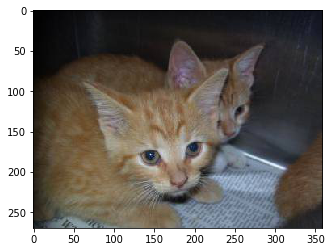

In [201]:
# Prepare for classification: step 1
# Note: Following code assumes that all the files in test set are numbered serially.
r = str(random.randint(1, test_generator.samples))
test_image_path = test_path+'test1/'+r+'.jpg'
# test_image_path = '<inset path here>'
image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=inputShape)
image = tf.keras.preprocessing.image.img_to_array(image)

# Prepare for classification: step 2
image = np.expand_dims(image, axis=0)

# Prepare for classification: step 3
image = preprocess(image)

# Predict the labels using the model
pred_test_image = model.predict(image)

# Print the labels and the image 
# print(np.around(pred_test_image))
img_class = np.around(pred_test_image)
if img_class[0][0] == 1:
    print("It's a CAT!", "(filename: "+r+")")
else:
    print("It's a DOG!", "(filename: "+r+")")
    
my_image = cv2.imread(test_image_path)
cv_rgb = cv2.cvtColor(my_image, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()